In [1]:
from PIL import Image
from datetime import datetime
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import BatchNormalization, Activation, GlobalAveragePooling2D, Lambda
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.metrics import classification_report, confusion_matrix
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import sklearn
import tensorflow as tf
import warnings

In [2]:
BATCH_SIZE = 64
NUM_CLASS = 200
train_dir = "/kaggle/input/ucsd-200/Train/Train"
test_dir = "/kaggle/input/ucsd-200/Test/Test"
train_txt_path = '/kaggle/input/ucsd-200/train.txt'
test_txt_path = '/kaggle/input/ucsd-200/test.txt'

#Reading the txt file
train_data, test_data = [], []
with open(train_txt_path, 'r') as train_file:
  train_data = train_file.read().splitlines()
with open(test_txt_path, 'r') as test_file:
  test_data = test_file.read().splitlines()

train_df = pd.DataFrame([x.split() for x in train_data], columns = ['filename', 'class'])
test_df = pd.DataFrame([x.split() for x in test_data], columns = ['filename', 'class'])

# Ensure filenames are sorted to avoid issues with file ordering
train_df = train_df.sort_values('filename').reset_index(drop=True)
test_df = test_df.sort_values('filename').reset_index(drop=True)

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    shear_range=0.2,  
    zoom_range=0.2, 
    horizontal_flip=True,  
    rotation_range=20, 
    width_shift_range=0.2, 
    height_shift_range=0.2,  
)


test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_augmented = train_datagen.flow_from_dataframe(
    train_df.sort_values('filename').reset_index(drop=True), 
    directory=train_dir,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True  
)


test_augmented = test_datagen.flow_from_dataframe(
    test_df.sort_values('filename').reset_index(drop=True),  
    directory=test_dir,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  
)

Found 4829 validated image filenames belonging to 200 classes.
Found 1204 validated image filenames belonging to 200 classes.


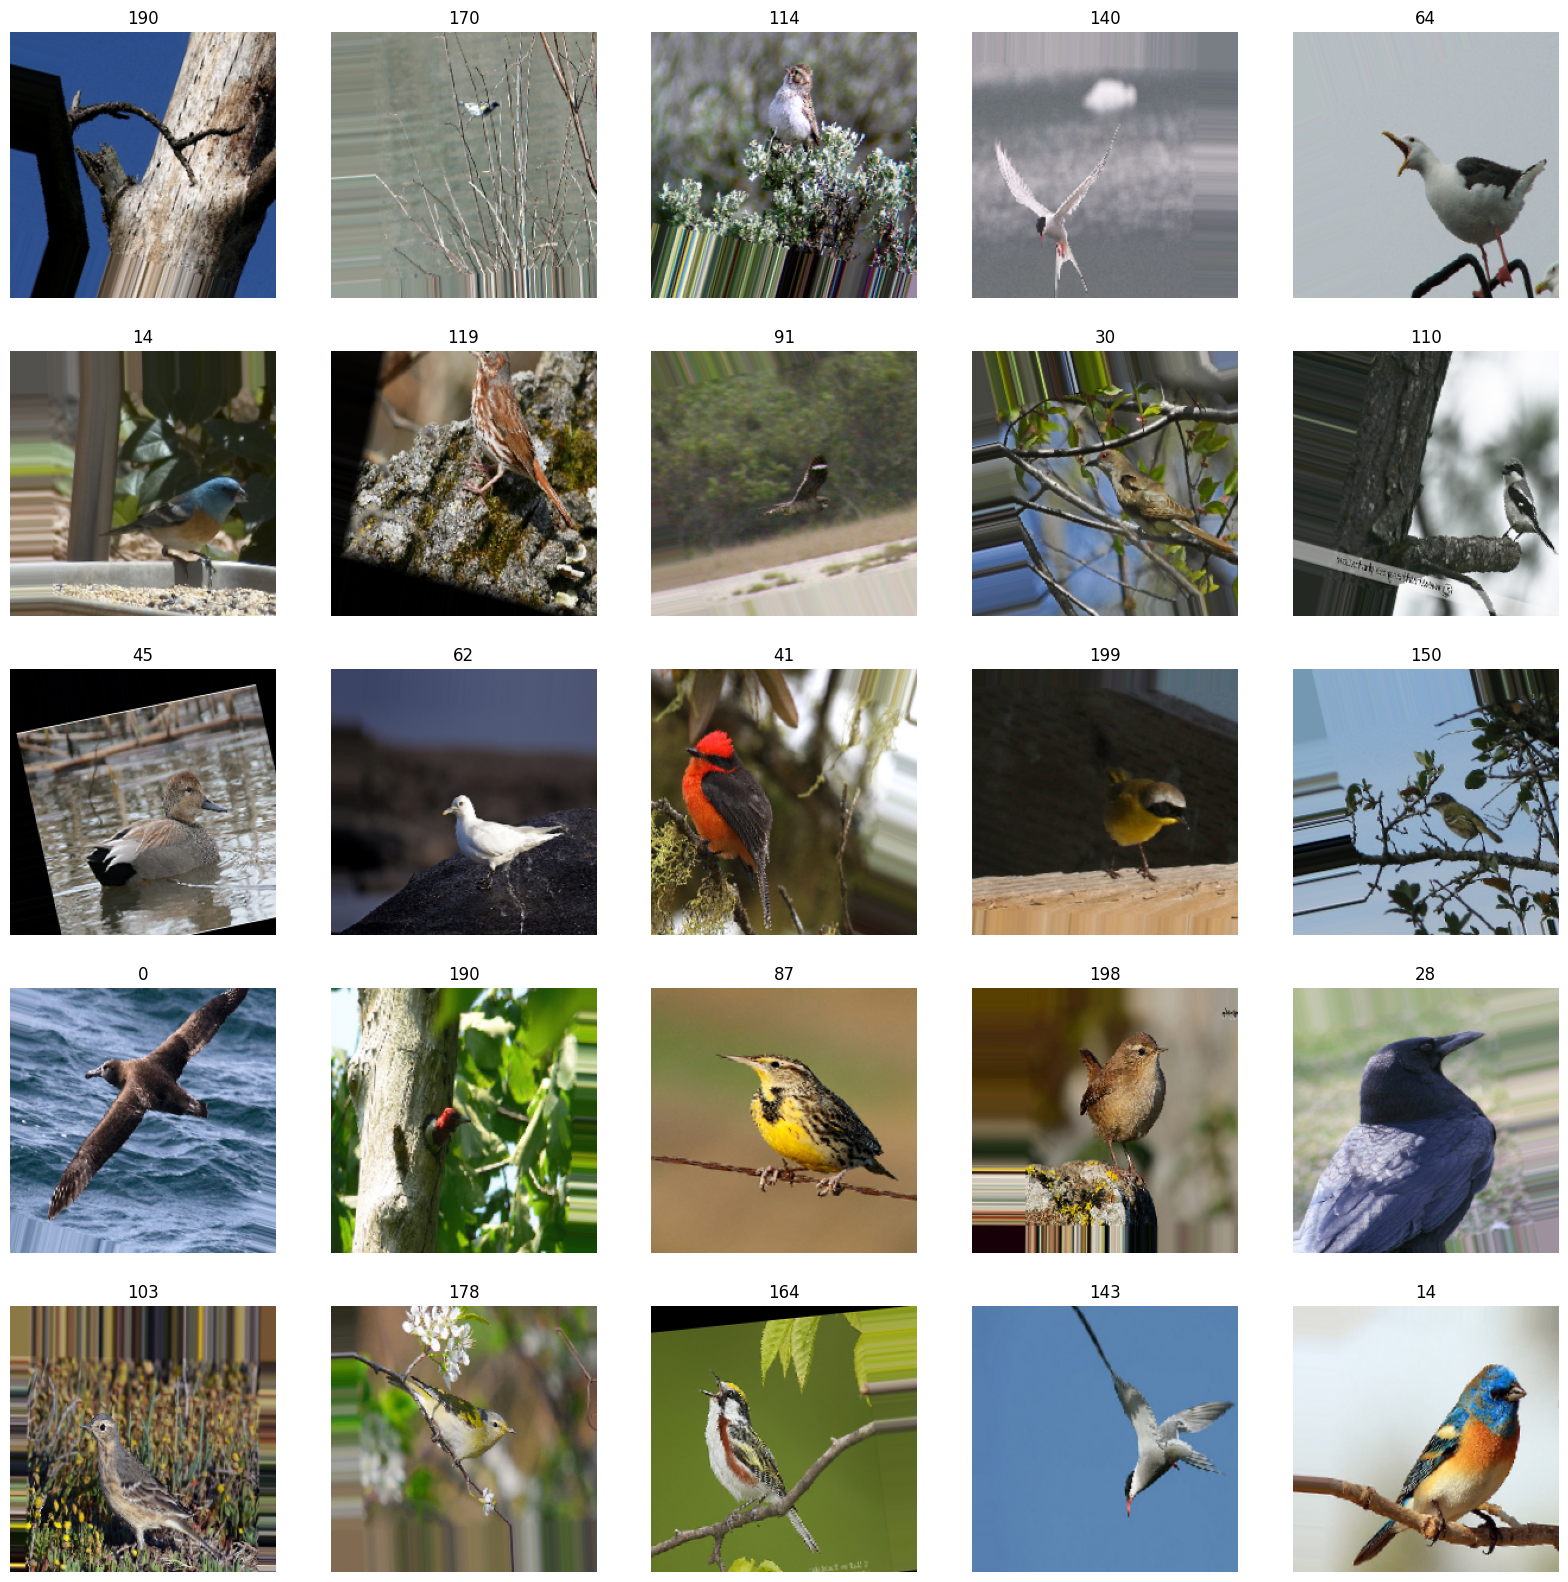

In [4]:
species_names = {v: k for k, v in train_augmented.class_indices.items()}

images, labels = next(train_augmented)

plt.figure(figsize=(20, 20))

for i in range(25): 
    ax = plt.subplot(5, 5, i + 1)
    
    img = images[i] * 255.0
    plt.imshow(img.astype(np.uint8))  

    label_index = np.argmax(labels[i])
    
    plt.title(species_names[label_index])  
    plt.axis('off')  

plt.show()

In [6]:
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Average
from tensorflow.keras.applications import ResNet50, MobileNetV2, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

IMG_SHAPE = (224, 224, 3)

resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)

for layer in resnet_base.layers[:-3]:
    layer.trainable = True
for layer in mobilenet_base.layers[:-3]:
    layer.trainable = True
for layer in efficientnet_base.layers[:-3]:
    layer.trainable = True

input_layer = Input(shape=IMG_SHAPE)

resnet_output = resnet_base(input_layer)
mobilenet_output = mobilenet_base(input_layer)
efficientnet_output = efficientnet_base(input_layer)

resnet_output = GlobalAveragePooling2D()(resnet_output)
mobilenet_output = GlobalAveragePooling2D()(mobilenet_output)
efficientnet_output = GlobalAveragePooling2D()(efficientnet_output)

resnet_output = Dense(200, activation='softmax', kernel_regularizer=l2(0.02), kernel_constraint=max_norm(3))(resnet_output)
mobilenet_output = Dense(200, activation='softmax', kernel_regularizer=l2(0.02), kernel_constraint=max_norm(3))(mobilenet_output)
efficientnet_output = Dense(200, activation='softmax', kernel_regularizer=l2(0.02), kernel_constraint=max_norm(3))(efficientnet_output)

#soft voting
voting_output = Average()([resnet_output, mobilenet_output, efficientnet_output])

x = Dropout(0.4)(voting_output)

model = Model(inputs=input_layer, outputs=voting_output)

model.compile(optimizer=Adam(learning_rate=3e-6),
              loss=CategoricalCrossentropy(label_smoothing=0.2),
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=8,  restore_best_weights=True,  verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=1e-8, verbose=1)

model.summary()

train_model = model.fit(
    train_augmented,
    steps_per_epoch=train_augmented.samples, 
    validation_data=test_augmented,
    validation_steps=test_augmented.samples,
    callbacks=[reduce_lr, early_stopping],
    epochs=200
)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ input_layer_7[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 7, 7,      │  2,257,984 │ input_layer_7[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 7, 7,      │  4,049,571 │ input_layer_7[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 200)       │    409,800 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 200)       │    256,200 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 200)       │    256,200 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_1 (Average) │ (None, 200)       │          0 │ dense_3[0][0],    │
│                     │                   │            │ dense_4[0][0],    │
│                     │                   │            │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 30,817,467 (117.56 MB)

 Trainable params: 1,750,616 (6.68 MB)

 Non-trainable params: 29,066,851 (110.88 MB)

Epoch 1/200
4829/4829 ━━━━━━━━━━━━━━━━━━━━ 155s 21ms/step - accuracy: 0.0039 - loss: 26.3831 - val_accuracy: 0.0042 - val_loss: 26.2639 - learning_rate: 3.0000e-06
Epoch 2/200
4829/4829 ━━━━━━━━━━━━━━━━━━━━ 75s 14ms/step - accuracy: 0.0064 - loss: 26.1540 - val_accuracy: 0.0050 - val_loss: 26.0394 - learning_rate: 3.0000e-06
Epoch 3/200
4829/4829 ━━━━━━━━━━━━━━━━━━━━ 76s 14ms/step - accuracy: 0.0064 - loss: 25.9383 - val_accuracy: 0.0058 - val_loss: 25.8191 - learning_rate: 3.0000e-06
Epoch 4/200
4829/4829 ━━━━━━━━━━━━━━━━━━━━ 83s 14ms/step - accuracy: 0.0056 - loss: 25.7158 - val_accuracy: 0.0075 - val_loss: 25.6018 - learning_rate: 3.0000e-06
Epoch 5/200
4829/4829 ━━━━━━━━━━━━━━━━━━━━ 76s 14ms/step - accuracy: 0.0079 - loss: 25.5021 - val_accuracy: 0.0083 - val_loss: 25.3869 - learning_rate: 3.0000e-06
Epoch 6/200
4829/4829 ━━━━━━━━━━━━━━━━━━━━ 77s 14ms/step - accuracy: 0.0083 - loss: 25.2847 - val_accuracy: 0.0108 - val_loss: 25.1740 - learning_rate: 3.0000e-06
Epoch 7/200
4829/4829

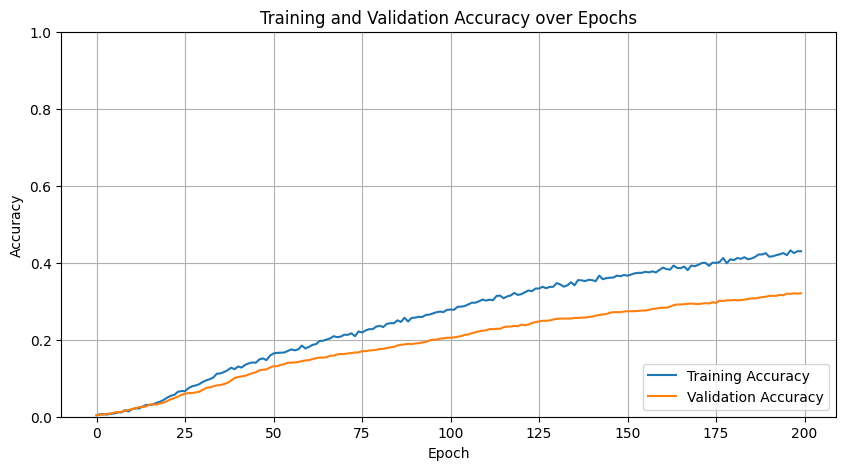

In [7]:
# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_model.history['accuracy'], label='Training Accuracy')
plt.plot(train_model.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1]) 
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
train_model = model.fit(
    train_augmented,
    steps_per_epoch=train_augmented.samples,  
    validation_data=test_augmented,
    validation_steps=test_augmented.samples,
    callbacks=[reduce_lr, early_stopping],
    epochs=200
)

Epoch 1/200
  76/4829 ━━━━━━━━━━━━━━━━━━━━ 1:02:55 794ms/step - accuracy: 0.5572 - loss: 4.7119

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


4829/4829 ━━━━━━━━━━━━━━━━━━━━ 73s 14ms/step - accuracy: 0.5573 - loss: 4.7039 - val_accuracy: 0.4111 - val_loss: 4.9121 - learning_rate: 3.0000e-06
Epoch 2/200
4829/4829 ━━━━━━━━━━━━━━━━━━━━ 73s 14ms/step - accuracy: 0.5639 - loss: 4.6918 - val_accuracy: 0.4103 - val_loss: 4.9090 - learning_rate: 3.0000e-06
Epoch 3/200
4829/4829 ━━━━━━━━━━━━━━━━━━━━ 83s 14ms/step - accuracy: 0.5634 - loss: 4.6998 - val_accuracy: 0.4111 - val_loss: 4.9060 - learning_rate: 3.0000e-06
Epoch 4/200
4829/4829 ━━━━━━━━━━━━━━━━━━━━ 73s 14ms/step - accuracy: 0.5638 - loss: 4.6976 - val_accuracy: 0.4120 - val_loss: 4.9030 - learning_rate: 3.0000e-06
Epoch 5/200
4829/4829 ━━━━━━━━━━━━━━━━━━━━ 73s 14ms/step - accuracy: 0.5647 - loss: 4.6910 - val_accuracy: 0.4128 - val_loss: 4.9001 - learning_rate: 3.0000e-06
Epoch 6/200
4829/4829 ━━━━━━━━━━━━━━━━━━━━ 75s 14ms/step - accuracy: 0.5604 - loss: 4.6850 - val_accuracy: 0.4120 - val_loss: 4.8971 - learning_rate: 3.0000e-06
Epoch 7/200
4829/4829 ━━━━━━━━━━━━━━━━━━━━ 78s